# Import and Download Libraries

In [1]:
%pip install contractions nlpaug


import pandas as pd
import numpy as np
import re, string
import contractions
from nltk.stem import WordNetLemmatizer
import contractions
import sys
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
from nlpaug.util import Action
import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 kB 6.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
## Deep learning Framework-Pythorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

## Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

## Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report,hamming_loss, accuracy_score

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")





Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_comments=pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
df_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


## Visualize Data

In [ ]:
toxic=df_comments["toxic"].value_counts().values[1]
severe_toxic=df_comments["severe_toxic"].value_counts().values[1]
obscene=df_comments["obscene"].value_counts().values[1]
threat=df_comments["threat"].value_counts().values[1]
insult=df_comments["insult"].value_counts().values[1]
identity_hate=df_comments["identity_hate"].value_counts().values[1]


In [ ]:
import plotly.graph_objects as go
fig=go.Figure([go.Bar(x=["toxic","severe_toxic","obscene","threat","insult","identity_hate"],y=[toxic,severe_toxic,obscene,threat,insult,identity_hate])])

In [ ]:
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="comment type",
    yaxis_title="Values")
fig.show()

In [ ]:
df_comments["toxic_label"]=(
    (df_comments["toxic"]==1)|
    (df_comments["severe_toxic"]==1)|
    (df_comments["obscene"]==1)|
    (df_comments["threat"]==1)|
    (df_comments["insult"]==1)|
    (df_comments["identity_hate"]==1)
).astype(int)
print(df_comments[["toxic","toxic_label"]].head())

   toxic  toxic_label
0      0            0
1      0            0
2      0            0
3      0            0
4      0            0


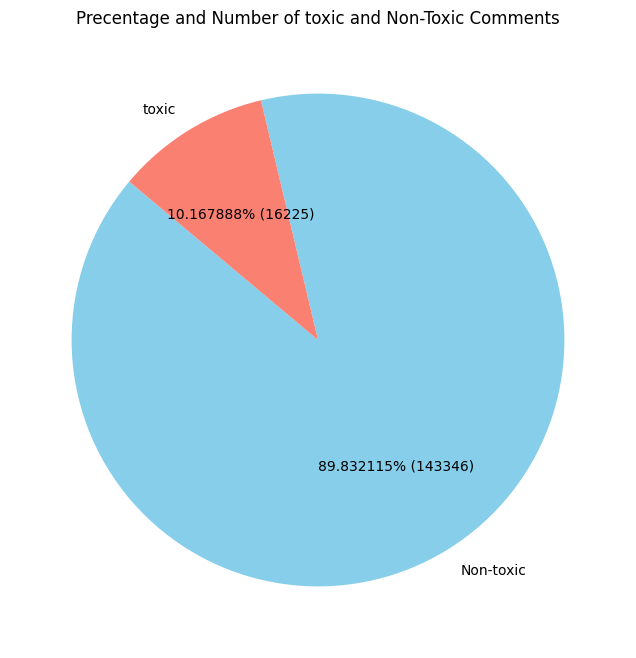

Number of non-toxic comments 143346
Number of toxic comments 16225
Precentage of non-toxic comments : 89.83%
Precentage of Toxic comments : 10.17%


In [ ]:
import matplotlib.pyplot as plt
toxic_count=df_comments["toxic_label"].value_counts()
toxic_precentage=df_comments["toxic_label"].value_counts(normalize=True)
plt.figure(figsize=(8,8))
plt.pie(toxic_count,labels=["Non-toxic","toxic"],autopct=lambda p: f"{p:1f}% ({int(p*sum(toxic_count)/100)})",
       startangle=140, colors=["skyblue","salmon"])
plt.title("Precentage and Number of toxic and Non-Toxic Comments")
plt.show()

print("Number of non-toxic comments",toxic_count[0])
print("Number of toxic comments",toxic_count[1])
print('Precentage of non-toxic comments : {:.2f}%'.format(toxic_precentage[0]*100))
print("Precentage of Toxic comments : {:.2f}%".format(toxic_precentage[1]*100))


## Clean Data

In [40]:
import nltk
nltk.download('wordnet')

def clean(row,index=None):

    text=row
    lemmatizer=WordNetLemmatizer()
    ans=text.translate(str.maketrans("\n"," "))
    ans=text.translate(str.maketrans("\n\n","  "))
    ans1=ans.translate(str.maketrans("—"," "))
    ans2 = " ".join(ans1.split())

    ans3 = re.sub(r'(!)1+', '', ans2)

    ans3=contractions.fix(ans3)
    doc = "".join([char for char in ans3 if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([lemmatizer.lemmatize(word) for word in doc.split()])

    ans4=doc.lower().strip()

    return ans4


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df_comments["comment_text"]=df_comments["comment_text"].apply(clean)


In [ ]:
df_comments

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_label
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he match this background colour i am seem...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestion on impr...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of asking when your vi...,0,0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself that is a ho...,0,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm there is no actual article for pro...,0,0,0,0,0,0,0
159569,fff125370e4aaaf3,and it look like it wa actually you who put on...,0,0,0,0,0,0,0


In [4]:
TARGET=["toxic"	,"severe_toxic","obscene","threat","insult","identity_hate"]

## Data agumentation

In [ ]:
##Synonym Agumentation
synomym_aug=naw.SynonymAug(aug_src="wordnet")
contextual_aug=naw.ContextualWordEmbsAug(model_path="bert-base-uncased",action="insert")
swap_aug=naw.RandomWordAug(action="swap")
delete_aug=naw.RandomWordAug(action="delete")


In [ ]:
def unique_words_augmentation(comment):
  words=comment.split()
  unique_words=list(set(words))
  return " ".join(unique_words)
def random_mask(comment,mask_ration=0.2):
  words=comment.split()
  num_words_to_mask=int(len(words)*mask_ration)
  mask_indices=random.sample(range(len(words)),num_words_to_mask)
  masked_words=[word for idx,word in enumerate(words) if idx not in mask_indices]
  return " ".join(masked_words)

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
augmented_data=[]

classes=["threat","identity_hate","severe_toxic"]
iteration_sizes=[3000,3000,3000]


for idx,class_name in enumerate(classes):
  toxic_comments=df_comments[(df_comments["toxic_label"]==1)
  & (df_comments[class_name]==1) ]
  for i in range(min(iteration_sizes[idx],len(toxic_comments))):
    print(f"Augmenting {class_name}, Iteration :{i} ")
    comment=toxic_comments["comment_text"].iloc[i]
    original_row=toxic_comments.iloc[i].to_dict()


    ## unique Words Agumentation
    unique_comment=unique_words_augmentation(comment)
    new_row=original_row.copy()
    new_row["comment_text"]=unique_comment
    augmented_data.append(new_row)

    ## Random Mask
    masked_comment=random_mask(comment)
    new_row=original_row.copy()
    new_row["comment_text"]=masked_comment
    augmented_data.append(new_row)

    ## Agumentation
    augmented_comment=synomym_aug.augment(comment)[0]
    new_row=original_row.copy()
    new_row["comment_text"]=augmented_comment
    augmented_data.append(new_row)

    augmented_comment=contextual_aug.augment(comment)[0]
    new_row=original_row.copy()
    new_row["comment_text"]=augmented_comment
    augmented_data.append(new_row)



    augmented_comment=swap_aug.augment(comment)[0]
    new_row=original_row.copy()
    new_row["comment_text"]=augmented_comment
    augmented_data.append(new_row)

    augmented_comment=delete_aug.augment(comment)[0]
    new_row=original_row.copy()
    new_row["comment_text"]=augmented_comment
    augmented_data.append(new_row)



agumented_df=pd.DataFrame(augmented_data)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Augmenting threat, Iteration :0 
Augmenting threat, Iteration :1 
Augmenting threat, Iteration :2 
Augmenting threat, Iteration :3 
Augmenting threat, Iteration :4 
Augmenting threat, Iteration :5 
Augmenting threat, Iteration :6 
Augmenting threat, Iteration :7 
Augmenting threat, Iteration :8 
Augmenting threat, Iteration :9 
Augmenting threat, Iteration :10 
Augmenting threat, Iteration :11 
Augmenting threat, Iteration :12 
Augmenting threat, Iteration :13 
Augmenting threat, Iteration :14 
Augmenting threat, Iteration :15 
Augmenting threat, Iteration :16 
Augmenting threat, Iteration :17 
Augmenting threat, Iteration :18 
Augmenting threat, Iteration :19 
Augmenting threat, Iteration :20 
Augmenting threat, Iteration :21 
Augmenting threat, Iteration :22 
Augmenting threat, Iteration :23 
Augmenting threat, Iteration :24 
Augmenting threat, Iteration :25 
Augmenting threat, Iteration :26 
Augmenting threat, Iteration :27 
Augmenting threat, Iteration :28 
Augmenting threat, Itera

In [ ]:
agumented_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_label
0,003217c3eb469ba9,stop again edits hi last my i am back or die u...,1,0,0,1,0,0,1
1,003217c3eb469ba9,am back again last warning stop undoing my edi...,1,0,0,1,0,0,1
2,003217c3eb469ba9,hullo i am backward again last word of advice ...,1,0,0,1,0,0,1
3,003217c3eb469ba9,hi and i... am back home again last warning......,1,0,0,1,0,0,1
4,003217c3eb469ba9,hi i am back again warning stop last undoing m...,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
20863,fd052883fa6a8697,shalom semite get fuck of here i will kill you...,1,1,1,1,1,1,1
20864,fd052883fa6a8697,shalom semite get the fuck out of hither i wil...,1,1,1,1,1,1,1
20865,fd052883fa6a8697,or shalom semite get the fuck out of here flat...,1,1,1,1,1,1,1
20866,fd052883fa6a8697,shalom semite get the fuck out of here i will ...,1,1,1,1,1,1,1


In [ ]:
agumented_df=pd.concat([df_comments,agumented_df],ignore_index=False)

In [ ]:
agumented_df.shape

(180439, 9)

In [ ]:
# train_df.to_csv("drive/MyDrive/train_augmented_data.csv",index=True)

## Visualize Data after augmentation

In [5]:
agumented_df=pd.read_csv("/content/drive/MyDrive/train_augmented_data.csv")


In [ ]:
agumented_df

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_label
0,0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,1,000103f0d9cfb60f,daww he match this background colour i am seem...,0,0,0,0,0,0,0
2,2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0,0
3,3,0001b41b1c6bb37e,more i cannot make any real suggestion on impr...,0,0,0,0,0,0,0
4,4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
180434,20863,fd052883fa6a8697,shalom semite get fuck of here i will kill you...,1,1,1,1,1,1,1
180435,20864,fd052883fa6a8697,shalom semite get the fuck out of hither i wil...,1,1,1,1,1,1,1
180436,20865,fd052883fa6a8697,or shalom semite get the fuck out of here flat...,1,1,1,1,1,1,1
180437,20866,fd052883fa6a8697,shalom semite get the fuck out of here i will ...,1,1,1,1,1,1,1


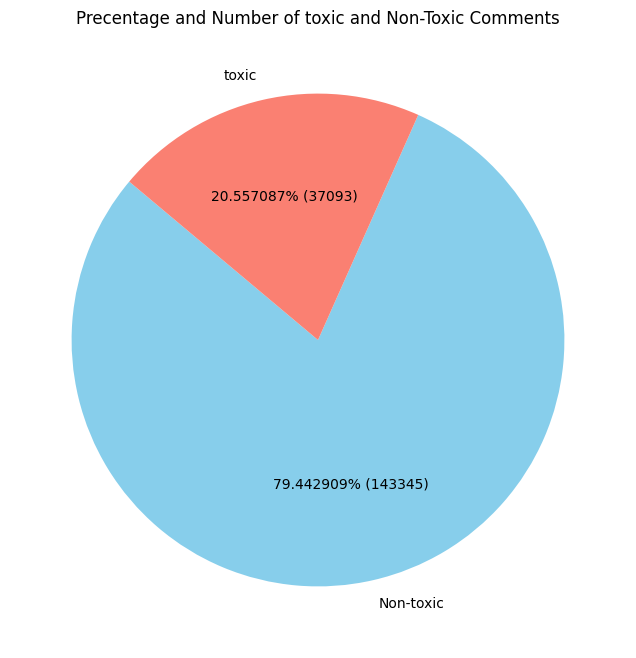

Number of non-toxic comments 143346
Number of toxic comments 37093
Precentage of non-toxic comments : 79.44%
Precentage of Toxic comments : 20.56%


In [ ]:
import matplotlib.pyplot as plt
agumented_df["toxic_label"]=(
    (agumented_df["toxic"]==1)|
    (agumented_df["severe_toxic"]==1)|
    (agumented_df["obscene"]==1)|
    (agumented_df["threat"]==1)|
    (agumented_df["insult"]==1)|
    (agumented_df["identity_hate"]==1)
).astype(int)
# print(agumented_df[["toxic","toxic_label"]].head())

toxic_count=agumented_df["toxic_label"].value_counts()
toxic_precentage=agumented_df["toxic_label"].value_counts(normalize=True)
plt.figure(figsize=(8,8))
plt.pie(toxic_count,labels=["Non-toxic","toxic"],autopct=lambda p: f"{p:1f}% ({int(p*sum(toxic_count)/100)})",
       startangle=140, colors=["skyblue","salmon"])
plt.title("Precentage and Number of toxic and Non-Toxic Comments")
plt.show()

print("Number of non-toxic comments",toxic_count[0])
print("Number of toxic comments",toxic_count[1])
print('Precentage of non-toxic comments : {:.2f}%'.format(toxic_precentage[0]*100))
print("Precentage of Toxic comments : {:.2f}%".format(toxic_precentage[1]*100))


In [ ]:
toxic=agumented_df["toxic"].value_counts().values[1]
severe_toxic=agumented_df["severe_toxic"].value_counts().values[1]
obscene=agumented_df["obscene"].value_counts().values[1]
threat=agumented_df["threat"].value_counts().values[1]
insult=agumented_df["insult"].value_counts().values[1]
identity_hate=agumented_df["identity_hate"].value_counts().values[1]


In [ ]:
fig=go.Figure([go.Bar(x=["toxic","severe_toxic","obscene","threat","insult","identity_hate"],y=[toxic,severe_toxic,obscene,threat,insult,identity_hate])])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="comment type",
    yaxis_title="Values")
fig.show()

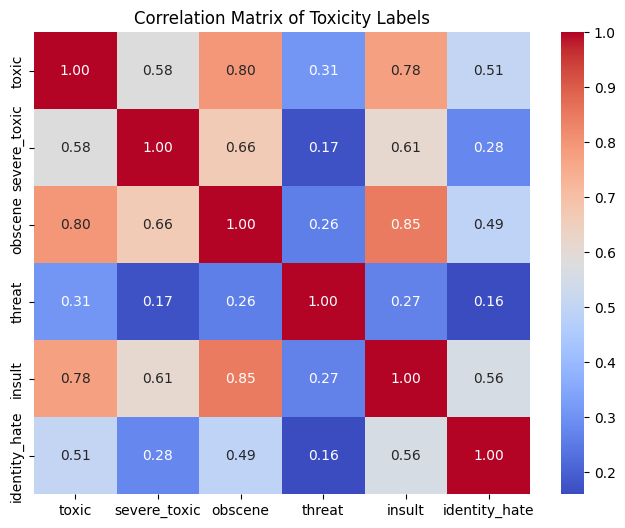

In [ ]:
## Multi-label Correlation
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(agumented_df[TARGET].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Matrix of Toxicity Labels")
plt.show()

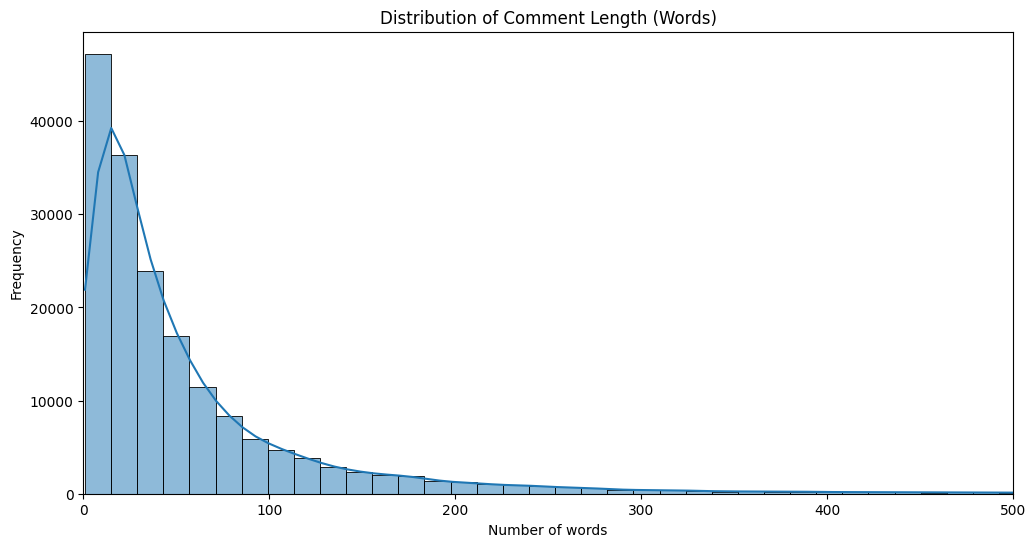

In [ ]:
## Comment Length Analysis
agumented_df["comment_length"]=agumented_df["comment_text"].apply(lambda x: len(x.split()) if (isinstance(x,str)) else None )
plt.figure(figsize=(12,6))
sns.histplot(agumented_df["comment_length"],bins=100,kde=True)
plt.title("Distribution of Comment Length (Words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.xlim(0,500)
plt.show()


# Tokenization with BERT

In [6]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class ToxicCommentDataset(Dataset):
  def __init__(self,comments, labels, tokenizer,max_len):
    self.comments=comments
    self.labels=labels
    self.tokenizer=tokenizer
    self.max_len=max_len
  def __len__(self):
    return len(self.comments)
  def __getitem__(self,item):
    comment=str(self.comments[item])
    target=self.labels[item]
    encoding=self.tokenizer.encode_plus(
        comment,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    return {
        "comment_text":comment,
        "inputs_id":encoding["input_ids"].flatten(),
        "attention_mask":encoding["attention_mask"].flatten(),
        "labels":torch.tensor(target,dtype=torch.float)
    }

In [8]:
## prepare data
X=agumented_df["comment_text"].values
y=agumented_df[TARGET].values

## Split Data
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,random_state=42)

## create datasets
train_dataset=ToxicCommentDataset(X_train,y_train,tokenizer,max_len=128)
val_dataset=ToxicCommentDataset(X_val,y_val,tokenizer,max_len=128)

## Create datasset Loader
train_data_loaders=DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=2)
val_data_loaders=DataLoader(val_dataset,batch_size=16,shuffle=False,num_workers=2)


# Model Definition

In [9]:
model=BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(TARGET),
                                                    output_attentions=False,
                                                    output_hidden_states=False)
model.to(device)
print("\nModel loaded successfully")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded successfully


# Model Training

In [10]:
optimizer=AdamW(model.parameters(),lr= 2e-5,eps=1e-8)
## total number of training steps
total_steps=len(train_data_loaders)* 3 ## EPOCHS

##learning rate scheduler
scheduler=get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
  num_training_steps=total_steps


)

##loss function
loss_fn=nn.BCEWithLogitsLoss().to(device)


In [11]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
  """
  steps:
  -Batch Iteration
  -Forward pass (outputs = model(...))
  -Loss computation (loss = loss_fn(logits, labels))
  -Backward pass (loss.backward())
  -Gradient clipping
  -Optimizer step (optimizer.step()) → this is where the weights actually get updated
  -Scheduler step (scheduler.step()) → adjusts your learning rate

  """
  model.train()
  total_loss=0
  num_batches=len(data_loader)

  for i,batch in enumerate(data_loader):
    ## Move batches to device
    input_ids=batch["inputs_id"].to(device)
    attention_mask=batch["attention_mask"].to(device)
    labels=batch["labels"].to(device)

    ## Clear previous gradients
    optimizer.zero_grad()

    # Forward pass
    outputs=model(
        input_ids=input_ids,
        attention_mask=attention_mask,

    )
    ##Raw model output before sigmoid
    logits=outputs.logits
    # Calculate loss
    loss=loss_fn(logits,labels)
    total_loss+=loss.item()

    # Backward pass
    loss.backward()

    ## Clip gradients to prevent exploding gradients
    nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)

    # Update parameters
    optimizer.step()
    scheduler.step() ## Update leaning rate

    # print progress
    # if( i+1 ) % 100==0:
    #   print(f"Batch {i+1}/{num_batches} || Loss: {loss.item():.4f}")


    if (i + 1) % 100 == 0:
      print(f'  Batch {i + 1}/{num_batches} | Loss: {loss.item():.4f}')
  avg_train_loss=total_loss/num_batches
  print(f"Average Training Loss : {avg_train_loss:.4f}")
  return avg_train_loss



In [12]:
## Evaluation loop

def eval_model(model, data_loader,loss_fn,device):
  model.eval()
  total_loss=0
  all_preds=[]
  all_labels=[]
  num_batches=len(data_loader)


  with torch.no_grad(): ## Disable gradient calculation
    for batch in data_loader:
      input_ids=batch["inputs_id"].to(device)
      attention_mask=batch["attention_mask"].to(device)
      labels=batch["labels"].to(device)
      # Forward pass
      outputs=model(
          input_ids=input_ids,
          attention_mask=attention_mask
      )
      logits=outputs.logits
      ## Calculate loss
      loss=loss_fn(logits,labels)
      total_loss+=loss.item()

      # Store predictions (probilities) and true labels
      # Apply sigmoid to logits to get Probabilities

      probs=torch.sigmoid(logits)
      all_preds.append(probs.cpu().numpy())
      all_labels.append(labels.cpu().numpy())

  avg_val_loss=total_loss/num_batches
  print(f"Average Validation Loss {avg_val_loss:.4f}")

  # Concatenate result from all batches
  all_preds=np.concatenate(all_preds,axis=0)
  all_labels=np.concatenate(all_labels,axis=0)

  # Calculate metrics (exmple :ROC AUC per label, then average)
  # Note : Handling potential errors if a label has only one class in the validation batch/set

  roc_auc_scores={}
  mean_roc_auc=0
  try:
    for i,label_name in enumerate(TARGET):
      # check if both classes are present for the current label
      if len(np.unique(all_labels[:,i]))>1:
        roc_auc_scores[label_name]=roc_auc_score(all_labels[:,i],all_preds[:,i])
      else:
        roc_auc_scores[label_name]=np.nan
    mean_roc_auc=np.nanmean(list(roc_auc_scores.values()))
    print(f"Mean ROC AUC : {mean_roc_auc:.4f}")
    print("Individual ROC AUC Scores:")
    for name,score in roc_auc_scores.items():
      print(f"{name}: {score:.4f} ")
  except Exception as e:
    print("Could not calculate ROC AUC : {e}")

  ## calculate Hamming loss (fraction of wrongly predicted labels)
  threshold=0.5
  binary_preds=(all_preds>threshold).astype(int)
  hamming=hamming_loss(all_labels,binary_preds)
  print(f"Hamming loss : {hamming:.4f}")


  return avg_val_loss,mean_roc_auc,hamming





In [13]:
## Execute Training and Evaluation
history={"train_loss":[],"val_loss":[],"val_roc_auc":[],"val_hamming":[]}

best_roc_auc=-1
best_model_state=None
EPOCHS=2

print("\nStarting Training ")

for epoch in range(EPOCHS):
  print(f"\n-- Epoch {epoch+1}/{EPOCHS} --- ")
  train_loss=train_epoch(model,train_data_loaders,loss_fn,optimizer,device,scheduler)
  history["train_loss"].append(train_loss)


  print(f"\n --- Validation Epoch {epoch+1} ---")

  val_loss,val_roc_auc,val_hamming=eval_model(model,val_data_loaders,loss_fn,device)
  history["val_loss"].append(val_loss)
  history["val_roc_auc"].append(val_roc_auc)
  history["val_hamming"].append(val_hamming)
  ## Save the best model based on validation ROC AUC
  if val_roc_auc>best_roc_auc:
    best_roc_auc=val_roc_auc
    best_model_state=model.state_dict()
    torch.save(best_model_state,"best_model_state.bin")
    print(f"** New best model saved with ROC AUC : {best_roc_auc:.4f} ** ")
    print("\n Training Finished")
    print(f" Best Validation ROC AUC :{best_roc_auc:.4f} ")
    if best_model_state:
      model.load_state_dict(best_model_state)
      print("Loaded best model state for prediction ")









Starting Training 

-- Epoch 1/2 --- 
  Batch 100/10150 | Loss: 0.2185
  Batch 200/10150 | Loss: 0.2070
  Batch 300/10150 | Loss: 0.0717
  Batch 400/10150 | Loss: 0.1339
  Batch 500/10150 | Loss: 0.1961
  Batch 600/10150 | Loss: 0.0550
  Batch 700/10150 | Loss: 0.0621
  Batch 800/10150 | Loss: 0.0869
  Batch 900/10150 | Loss: 0.2435
  Batch 1000/10150 | Loss: 0.0234
  Batch 1100/10150 | Loss: 0.1300
  Batch 1200/10150 | Loss: 0.0706
  Batch 1300/10150 | Loss: 0.0986
  Batch 1400/10150 | Loss: 0.1017
  Batch 1500/10150 | Loss: 0.0258
  Batch 1600/10150 | Loss: 0.0706
  Batch 1700/10150 | Loss: 0.0198
  Batch 1800/10150 | Loss: 0.0977
  Batch 1900/10150 | Loss: 0.2170
  Batch 2000/10150 | Loss: 0.0938
  Batch 2100/10150 | Loss: 0.0921
  Batch 2200/10150 | Loss: 0.1435
  Batch 2300/10150 | Loss: 0.0480
  Batch 2400/10150 | Loss: 0.0913
  Batch 2500/10150 | Loss: 0.0834
  Batch 2600/10150 | Loss: 0.1018
  Batch 2700/10150 | Loss: 0.0832
  Batch 2800/10150 | Loss: 0.1914
  Batch 2900/10150

In [ ]:
history["val_loss"]

In [ ]:
range(0, 1 + 1)

range(0, 2)

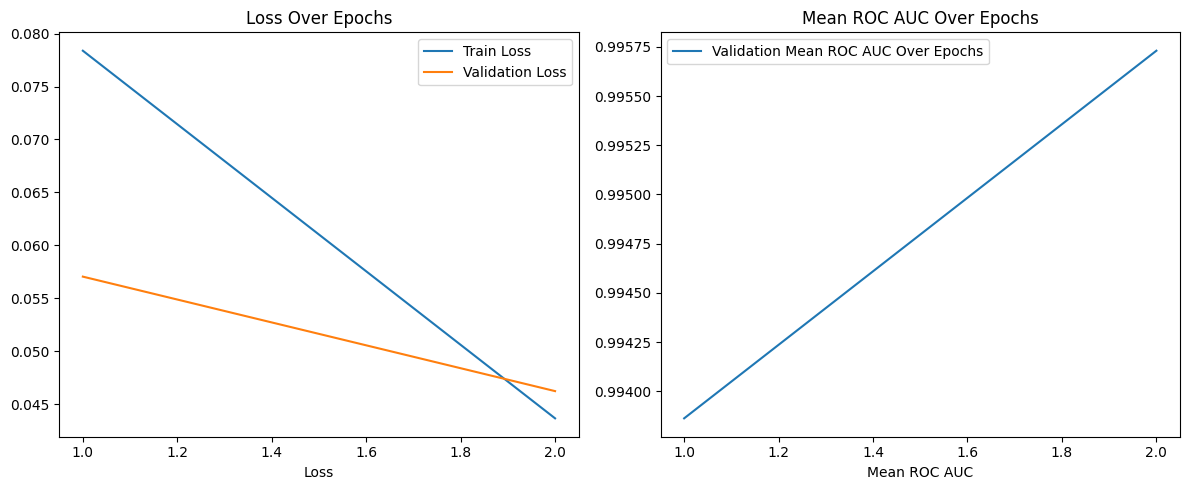

In [14]:
## plot training History
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, EPOCHS + 1),history["train_loss"],label="Train Loss")
plt.plot(range(1, EPOCHS + 1),history["val_loss"],label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.xlabel("Loss")
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS + 1),
history["val_roc_auc"],label="Validation Mean ROC AUC Over Epochs")
plt.title("Mean ROC AUC Over Epochs")
plt.xlabel("Epochs")
plt.xlabel("Mean ROC AUC")
plt.legend()

plt.tight_layout()
plt.show()




# Prediction Test Dataset

In [16]:
from google.colab import files
files.upload()  # Select kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oula23","key":"23097febc5c9b1ac6a4b70d11ff71f01"}'}

In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [24]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -f test.csv.zip


  0% 0.00/23.4M [00:00<?, ?B/s]
100% 23.4M/23.4M [00:00<00:00, 382MB/s]


In [33]:
import zipfile

with zipfile.ZipFile('/content/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/temp')
test_df = pd.read_csv('/kaggle/temp/test.csv')

In [1]:
# test_df=test_df["comment_text"].apply(clean)

In [48]:
class TestCommentDataset(Dataset):
    def __init__(self, comments, tokenizer, max_len):
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

test_texts=test_df["comment_text"].values
test_dataset=TestCommentDataset(test_texts,tokenizer,max_len=128)
test_dataloader=DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=2)

In [ ]:
def predict(model,data_loader,device):
  model.eval()
  predictions=[]

  print("\n Generating predictions on test data.. ")
  with torch.no_grad():
    for batch in data_loader:
      input_ids=batch["input_ids"].to(device)
      attention_mask=batch["attention_mask"].to(device)
      outputs=model(input_ids=input_ids,
                    attention_mask=attention_mask)
      logits=outputs.logits
      probs=torch.sigmoid(logits) ## Convert logits to probabilities (0-1 range)
      predictions.append(probs.cpu().numpy())
  return np.concatenate(predictions,axis=0)



test_predictions=predict(model,test_dataloader,device)
print("Predictions generated successfully.")
# print("shape of predictions ",test_predections.shape)


 Generating predictions on test data.. 


In [3]:
# !pip install nbstripout


#Train BERT using Trainer Args

In [ ]:
agumented_df["labels"]=agumented_df[TARGET].values.tolist()

In [ ]:
from sklearn.model_selection import train_test_split

sampled_df = agumented_df.sample(n=500, random_state=42)
train_text, test_text,train_labels,test_labels = train_test_split(
    sampled_df["comment_text"].tolist(),
    sampled_df["labels"].tolist(),
    test_size=100,
    random_state=42
)

In [ ]:
from transformers import BertTokenizer,BertForSequenceClassification, Trainer, TrainingArguments


In [ ]:
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")
def tokeniz_fn(examples):
  return tokenizer(examples,padding="max_length",truncation=True,max_length=256)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_train_data=tokeniz_fn(train_text)
tokenized_test_data=tokeniz_fn(test_text)

In [ ]:
import torch

class ToxicDataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels
  def __getitem__(self,idx):
    item={key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item["labels"]=torch.tensor(self.labels[idx],dtype=torch.float)
    return item
  def __len__(self):
    return len(self.labels)


train_dataset=ToxicDataset(tokenized_train_data,train_labels)
test_dataset=ToxicDataset(tokenized_test_data,test_labels)

In [ ]:
model=BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"                                                    )

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# for layer in model.bert.encoder.layer:
#   print(layer)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(pred):
  logits, labels=pred
  probs=torch.sigmoid(torch.tensor(logits)).numpy()
  preds=(probs>=0.5).astype(int)

  f1_score=f1_score(labels,preds,average="macro")
  acc=accuracy_score(labels,preds)

  return {"accuracy": acc, "f1":f1_score}



In [ ]:
from transformers import Trainer,TrainingArguments,TrainerCallback
import os
os.environ["WAND_DISABLED"]="true"


In [ ]:
class PrintCallback(TrainerCallback):
  def on_log(self,args,state,control,logs=None,**kwargs):
    if logs:
      print(logs)


training_args=TrainingArguments(
    output_dir="/content/results",
    run_name="toxic-bert-run",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    do_eval=True,
    logging_dir="./logs",
    logging_steps=100,
    save_strategy="no",
    load_best_model_at_end=False,

)

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[PrintCallback()]
)



In [ ]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: oulakh23 (oulakh23-cc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.308000
200,0.130400
300,0.094900


{'loss': 0.308, 'grad_norm': 0.5268675684928894, 'learning_rate': 3.35e-05, 'epoch': 1.0}
{'loss': 0.1304, 'grad_norm': 0.1594688445329666, 'learning_rate': 1.6833333333333334e-05, 'epoch': 2.0}
{'loss': 0.0949, 'grad_norm': 1.8983901739120483, 'learning_rate': 1.6666666666666668e-07, 'epoch': 3.0}
{'train_runtime': 4101.0981, 'train_samples_per_second': 0.293, 'train_steps_per_second': 0.073, 'total_flos': 157872302899200.0, 'train_loss': 0.17778474807739258, 'epoch': 3.0}


TrainOutput(global_step=300, training_loss=0.17778474807739258, metrics={'train_runtime': 4101.0981, 'train_samples_per_second': 0.293, 'train_steps_per_second': 0.073, 'total_flos': 157872302899200.0, 'train_loss': 0.17778474807739258, 'epoch': 3.0})

# Inference

In [ ]:
def predict(text):
  model.eval()
  device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
  inputs=tokenizer(text, return_tensors="pt",truncation=True, padding=True, max_length=256).to(device)
  ## Also move model to correct device
  model.to(device)
  with torch.no_grad():
    outputs=model(**inputs)
    probs=torch.sigmoid(outputs.logits).detach().cpu().numpy()
    return dict(zip(TARGET,probs[0]))


In [ ]:
text="You are the worst human being"
prediction= predict(text)


In [ ]:
# prediction

for label,score in prediction.items():
  print(f"{label} : {score}")

toxic : 0.8293028473854065
severe_toxic : 0.2513073980808258
obscene : 0.6444095373153687
threat : 0.13280288875102997
insult : 0.7240422964096069
identity_hate : 0.40693315863609314
